<a href="https://colab.research.google.com/github/NikitaPoly/Weather-Station-Model/blob/master/MicroWeatherStation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

In [27]:
#Data API
!pip install wwo-hist


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
#Get the Data
from wwo_hist import retrieve_hist_data 

In [29]:
frequency=1#hourly frequency (every hour) 
api_key = '9acd0fc65e234d6bbd115201230205'
location_list = ['canazei']

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                '01-JAN-2011',
                                '31-DEC-2020',
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for canazei


Currently retrieving data for canazei: from 2011-01-01 to 2011-01-31


/usr/local/lib/python3.10/dist-packages/wwo_hist/__init__.py:69: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_begin = pd.date_range(start_date, end_date, freq='MS', closed='right')
/usr/local/lib/python3.10/dist-packages/wwo_hist/__init__.py:74: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_end = pd.date_range(start_date, end_date, freq='M', closed='left')


Time elapsed (hh:mm:ss.ms) 0:00:03.200002
Currently retrieving data for canazei: from 2011-02-01 to 2011-02-28
Time elapsed (hh:mm:ss.ms) 0:00:05.024106
Currently retrieving data for canazei: from 2011-03-01 to 2011-03-31
Time elapsed (hh:mm:ss.ms) 0:00:08.393434
Currently retrieving data for canazei: from 2011-04-01 to 2011-04-30
Time elapsed (hh:mm:ss.ms) 0:00:10.624429
Currently retrieving data for canazei: from 2011-05-01 to 2011-05-31
Time elapsed (hh:mm:ss.ms) 0:00:12.680766
Currently retrieving data for canazei: from 2011-06-01 to 2011-06-30
Time elapsed (hh:mm:ss.ms) 0:00:16.027972
Currently retrieving data for canazei: from 2011-07-01 to 2011-07-31
Time elapsed (hh:mm:ss.ms) 0:00:17.685688
Currently retrieving data for canazei: from 2011-08-01 to 2011-08-31
Time elapsed (hh:mm:ss.ms) 0:00:19.338407
Currently retrieving data for canazei: from 2011-09-01 to 2011-09-30
Time elapsed (hh:mm:ss.ms) 0:00:21.004863
Currently retrieving data for canazei: from 2011-10-01 to 2011-10-31
T

In [30]:
# Extract temperature, humidity and precipitation
t_list = df_weather[0].tempC.astype(float).to_list()
h_list = df_weather[0].humidity.astype(float).to_list()
s_list = df_weather[0].totalSnow_cm.astype(float).to_list()

In [31]:
import matplotlib.pyplot as plt

<ipython-input-32-96bfd36d7361>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('gray_r')


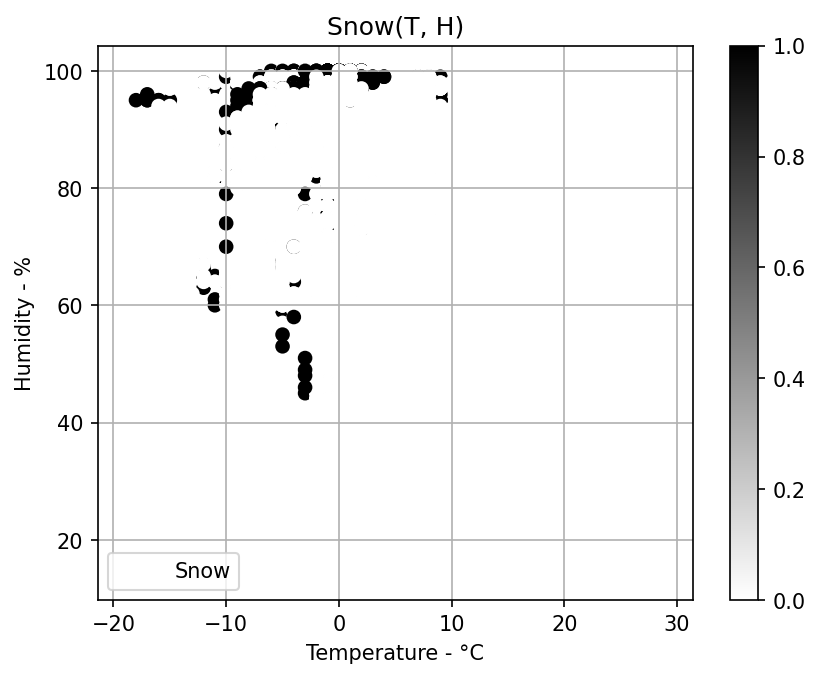

In [32]:
# Create the number representation of the classification
def binarize(snow, threshold):
  if snow > threshold:
    return 1
  else:
    return 0

s_bin_list = [binarize(snow, 0.5) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, label="Snow")
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

In [33]:
# create output labels or classes
def gen_label(snow, temperature):
  if snow > .5 and temperature < 2:
    return "Yes"
  else:
    return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [34]:
import pandas as pd

In [35]:
# make the dataset inputs and outputs all in one column
# this data set 
csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)

In [36]:
print(df_dataset)

       Temp0  Temp1  Temp2  Humi0  Humi1  Humi2 Snow
0      -11.0  -12.0  -13.0   90.0   91.0   92.0   No
1      -12.0  -13.0  -13.0   91.0   92.0   93.0   No
2      -13.0  -13.0  -14.0   92.0   93.0   93.0   No
3      -13.0  -14.0  -15.0   93.0   93.0   93.0   No
4      -14.0  -15.0  -16.0   93.0   93.0   93.0   No
...      ...    ...    ...    ...    ...    ...  ...
87665   -8.0   -8.0   -9.0   91.0   93.0   92.0   No
87666   -8.0   -9.0   -9.0   93.0   92.0   92.0   No
87667   -9.0   -9.0  -10.0   92.0   92.0   91.0   No
87668   -9.0  -10.0  -10.0   92.0   91.0   87.0   No
87669  -10.0  -10.0  -10.0   91.0   87.0   84.0   No

[87670 rows x 7 columns]


In [37]:
df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  df_dataset = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

,Before - %,After - %
Class,,
% No Snow,94.44,50.0
% Snow,5.56,50.0


In [38]:
#iportant to make sure all the inputs are simular range
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# Scaling with Z-score function
def scaling(val, avg, std):
  return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

COPY ME!
Temperature - [MEAN, STD]   2.17114 6.99078
Humidity - [MEAN, STD]      85.64869 13.93273


<ipython-input-39-180eac70d47c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(t_list, ax=ax[0])
<ipython-input-39-180eac70d47c>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(h_list, ax=ax[1])
<ipython-input-39-180eac70d47c>:15: UserWarning: 

`distplot` is a deprecated function and will b

Text(0.5, 1.0, 'Normalized humidity')

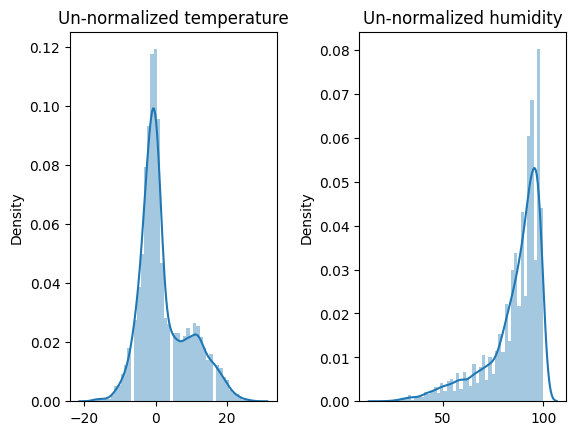

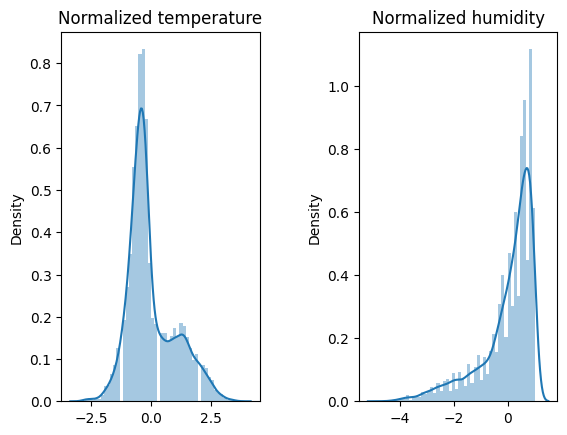

In [39]:
t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(t_list, ax=ax[0])
ax[0].set_title("Un-normalized temperature")
sns.distplot(h_list, ax=ax[1])
ax[1].set_title("Un-normalized humidity")

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
sns.distplot(t_norm_list, ax=ax[0])
ax[0].set_title("Normalized temperature")
sns.distplot(h_norm_list, ax=ax[1])
ax[1].set_title("Normalized humidity")

In [40]:
#seperate input features and output labels
f_names = df_dataset.columns.values[0:6]
l_name  = df_dataset.columns.values[6:7]
x = df_dataset[f_names]
y = df_dataset[l_name]

In [41]:
#convert output labels to numeric values
labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

In [42]:
#split data set
# Split 1 (85% vs 15%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)

In [43]:
# create model
model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [44]:
#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
#train
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_validate, y_validate))

Epoch 1/10
130/130 [==============================] - 1s 5ms/step - loss: 0.3063 - accuracy: 0.8663 - val_loss: 0.2909 - val_accuracy: 0.8743
Epoch 2/10
130/130 [==============================] - 1s 4ms/step - loss: 0.3070 - accuracy: 0.8681 - val_loss: 0.2899 - val_accuracy: 0.8757
Epoch 3/10
130/130 [==============================] - 0s 3ms/step - loss: 0.3041 - accuracy: 0.8697 - val_loss: 0.2890 - val_accuracy: 0.8743
Epoch 4/10
130/130 [==============================] - 0s 2ms/step - loss: 0.3022 - accuracy: 0.8664 - val_loss: 0.2879 - val_accuracy: 0.8770
Epoch 5/10
130/130 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8656 - val_loss: 0.2871 - val_accuracy: 0.8784
Epoch 6/10
130/130 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.8670 - val_loss: 0.2870 - val_accuracy: 0.8798
Epoch 7/10
130/130 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.8668 - val_loss: 0.2861 - val_accuracy: 0.8798
Epoch 

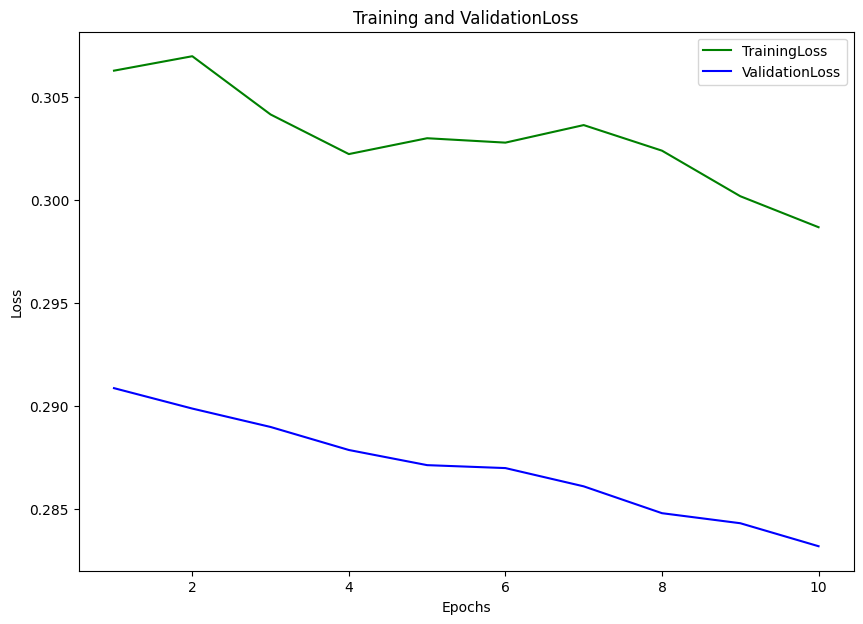

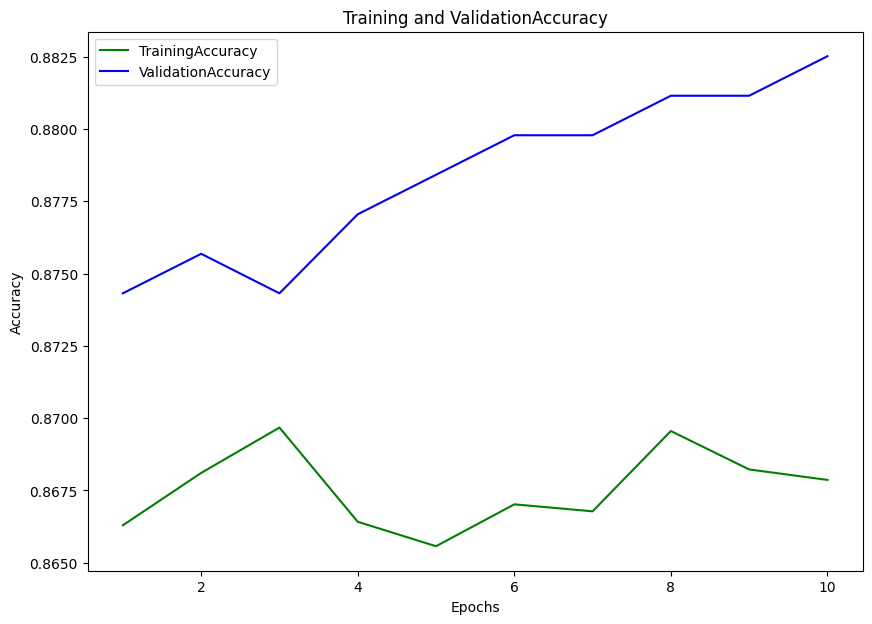

In [50]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, 10 + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend()
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

In [79]:
model.save("snow_forecast")

23/23 [==============================] - 0s 1ms/step


<Figure size 1000x700 with 0 Axes>

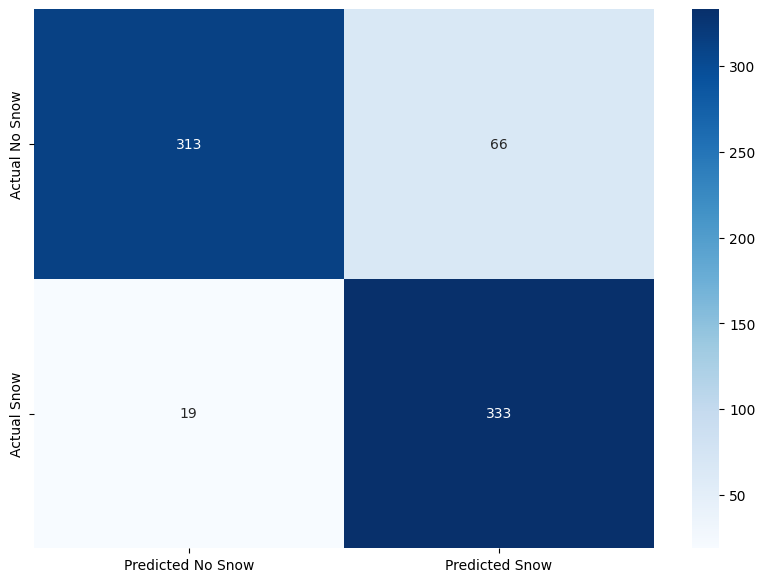

<Figure size 1000x700 with 0 Axes>

In [80]:
y_test_pred = model.predict(x_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.figure(figsize = (10,7))

In [81]:
#confusion matrix calculation
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

Accuracy:   0.884
Recall:     0.946
Precision:  0.835
F-score:    0.887


In [82]:
#Select randomly some samples from the data set to use for quatization
def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [84]:
#load model into converter
converter = tf.lite.TFLiteConverter.from_saved_model("snow_forecast")

In [85]:
#initialize 8 bit quantization
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [86]:
# do the conversion
tflite_model_quant = converter.convert()
open("snow_forecast_model.tflite", "wb").write(tflite_model_quant)

2088

In [87]:
#genrate .h file for the tflite thing
!apt-get update && apt-get -qq install xxd
!xxd -i snow_forecast_model.tflite > model.h
!cat model.h
     

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
unsigned char snow_forecast_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x